<h2>Load dataset from Google Colab</h2>

In [1]:
!pip install kaggle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!mkdir ~/.kaggle

In [4]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d arjunashok33/miniimagenet

100% 6.27G/6.28G [01:04<00:00, 93.5MB/s]
100% 6.28G/6.28G [01:05<00:00, 104MB/s] 


<h2>Unzip Dataset</h2>

In [7]:
zip_path = '/content/miniimagenet.zip'
extract_path = '/content/miniimagenet'

!unzip -q {zip_path} -d {extract_path}

In [8]:
import os
print(len(os.listdir('/content/miniimagenet')))

100


<h2>Start train and test</h2>

In [9]:
import os
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torch.utils.data import DataLoader
from torchvision import transforms
from torch import nn, optim

In [10]:
ImageSize=84

In [11]:
data_dir = '/content/miniimagenet'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0,), (1,)),
    transforms.Resize([ImageSize, ImageSize]),
])

dataset = ImageFolder(data_dir, transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [12]:
print(len(train_dataset),len(test_dataset))

48000 12000


torch.Size([3, 84, 84])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


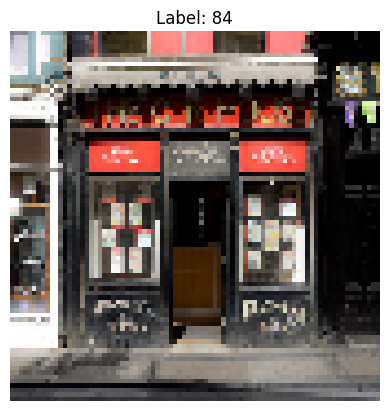

In [13]:
import matplotlib.pyplot as plt

image_index = 10

dataset = train_dataset

image, label = dataset[image_index]
print(image.shape)
plt.imshow(image.permute(1, 2, 0))
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

<h2>Implement Prototypical Network</h2>

In [14]:
from torchvision.models import resnet18

In [15]:
class PrototypicalNetworks(nn.Module):
  def __init__(self,backbone:nn.Module):
    super(PrototypicalNetworks,self).__init__()
    self.backbone=backbone
  def forward(self,support_images:torch.Tensor,support_labels:torch.Tensor,query_images: torch.Tensor):

    z_support=self.backbone.forward(support_images)
    z_query=self.backbone.forward(query_images)

    n_way=len(torch.unique(support_labels))

    z_proto = torch.cat(
        [
            z_support[torch.nonzero(support_labels == label)].mean(0)
            for label in range(n_way)
        ]
    )

    dists = torch.cdist(z_query, z_proto)
    scores = -dists
    return scores


In [40]:
convolutional_network=resnet18(pretrained=True)
convolutional_network.fc=nn.Flatten()

print(convolutional_network)

model=PrototypicalNetworks(convolutional_network).cuda()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

<h2>Create Support and Query Images</h2>

In [17]:
!pip install easyfsl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.8/72.8 kB 1.7 MB/s eta 0:00:00


In [18]:
from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average
from torch.utils.data import Dataset


In [19]:
print(type(test_dataset))

<class 'torch.utils.data.dataset.Subset'>


In [20]:
from torch.utils.data import random_split, Subset
# Create a subset of train_dataset with the first 10 instances
subset_train_dataset = Subset(train_dataset, range(10))
subset_train_dataset.get_labels = lambda: [instance[1] for instance in subset_train_dataset]
labels = subset_train_dataset.get_labels()
label_instance_0 = labels[9]
print(label_instance_0)

31


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [21]:
N_WAY = 5  # Number of classes in a task
N_SHOT = 5  # Number of images per class in the support set
N_QUERY = 10  # Number of images per class in the query set
N_EVALUATION_TASKS = 100


# Assign the lambda function to get_labels
test_dataset.get_labels = lambda: [instance[1] for instance in test_dataset]

test_sampler = TaskSampler(
    test_dataset, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

test_loader = DataLoader(
    test_dataset,
    batch_sampler=test_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [22]:
print(len(test_sampler))
print(len(test_loader))

100
100


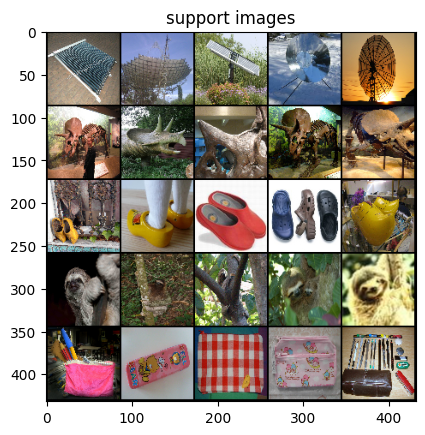

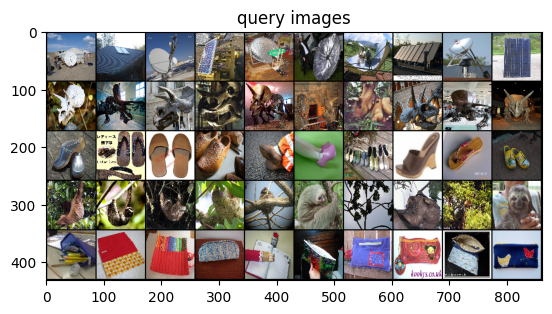

In [23]:
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(test_loader))

plot_images(example_support_images, "support images", images_per_row=N_SHOT)
plot_images(example_query_images, "query images", images_per_row=N_QUERY)

In [24]:
print(example_support_labels)
print(example_query_labels)

tensor([4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 2, 2, 2, 2,
        2])
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2])


In [25]:
model.eval()
example_scores = model(
    example_support_images.cuda(),
    example_support_labels.cuda(),
    example_query_images.cuda(),
).detach()

_, example_predicted_labels = torch.max(example_scores.data, 1)

print(example_predicted_labels)
# print("Ground Truth / Predicted")
# for i in range(len(example_query_labels)):
#     print(
#         f"{test_dataset._characters[example_class_ids[example_query_labels[i]]]} / {test_dataset._characters[example_class_ids[example_predicted_labels[i]]]}"
#     )

tensor([0, 4, 4, 0, 0, 0, 1, 2, 4, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 3, 2, 3, 3,
        1, 3, 0, 3, 3, 3, 0, 3, 0, 0, 4, 0, 0, 1, 0, 1, 3, 2, 2, 2, 2, 4, 2, 2,
        4, 2], device='cuda:0')


In [26]:
from tqdm import tqdm

In [27]:
def evaluate_on_one_task(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (
        torch.max(
            model(support_images.cuda(), support_labels.cuda(), query_images.cuda())
            .detach()
            .data,
            1,
        )[1]
        == query_labels.cuda()
    ).sum().item(), len(query_labels)


def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
    model.eval()
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(enumerate(data_loader), total=len(data_loader)):

            correct, total = evaluate_on_one_task(
                support_images, support_labels, query_images, query_labels
            )

            total_predictions += total
            correct_predictions += correct

    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
    )


evaluate(test_loader)

100%|██████████| 100/100 [00:54<00:00,  1.83it/s]

Model tested on 100 tasks. Accuracy: 63.26%


<h2>Train the model</h2>

In [34]:
N_TRAINING_EPISODES = 4000
N_VALIDATION_TASKS = 100

train_dataset.get_labels = lambda: [instance[1] for instance in train_dataset]
train_sampler = TaskSampler(
    train_dataset, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)
train_loader = DataLoader(
    train_dataset,
    batch_sampler=train_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


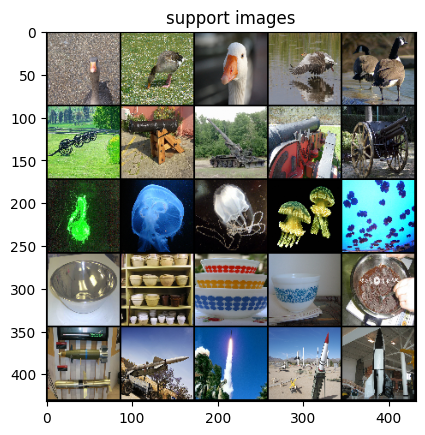

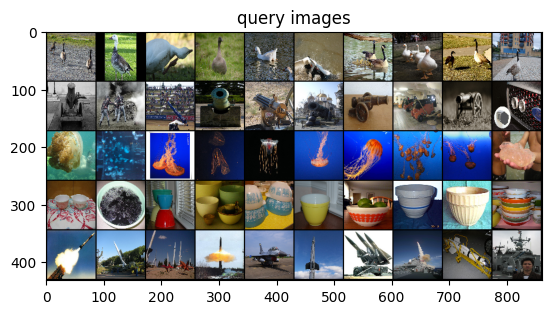

In [35]:
(
    example_support_images_train,
    example_support_labels_train,
    example_query_images_train,
    example_query_labels_train,
    example_class_ids_train,
) = next(iter(train_loader))

plot_images(example_support_images_train, "support images", images_per_row=N_SHOT)
plot_images(example_query_images_train, "query images", images_per_row=N_QUERY)

In [41]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()

In [37]:
# Train the model yourself with this cell

log_update_frequency = 10

all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

100%|██████████| 4000/4000 [35:07<00:00,  1.90it/s, loss=0.449]


In [38]:
# Save the model's state_dict
torch.save(model.state_dict(), '/content/drive/MyDrive/prototypical.pth')

In [39]:
evaluate(test_loader)

100%|██████████| 100/100 [00:51<00:00,  1.95it/s]

Model tested on 100 tasks. Accuracy: 75.10%


In [42]:
model.load_state_dict(torch.load('/content/drive/MyDrive/prototypical.pth'))

<All keys matched successfully>

In [44]:
print(model)

PrototypicalNetworks(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=T